In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_V2-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


In [ ]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Dieta1_DRDINT,Dieta1_DR1TFIBE,Quest21_SLQ300,Quest19_PAD660,Quest19_PAQ635,Dieta1_DR1TCHOL,Quest19_PAQ655,Dieta1_DR1TSFAT,Dieta1_DR1TKCAL,Exami2_BMXBMI,...,Quest1_ALQ111,Quest10_ECQ020,Quest16_MCQ220,Quest4_CBD121,Quest16_MCQ366A,Labor2_URDFLOW1,Demog1_DMDEDUC,Quest9_DLQ050,Quest20_PFQ061C,Quest16_MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,1,0,2,2,2.0,0,2,1,0,2,...,1.0,9.0,2.0,7.500000e+01,2.0,1.204,2.0,2.0,1.0,2.0
93708.0,1,2,2,2,2.0,0,2,1,0,0,...,2.0,9.0,2.0,5.397605e-79,2.0,0.500,1.0,2.0,2.0,2.0
93709.0,0,2,2,1,2.0,2,1,2,1,3,...,9.0,9.0,2.0,4.000000e+01,2.0,0.107,4.0,1.0,9.0,2.0
93711.0,1,3,1,0,1.0,3,3,3,3,0,...,1.0,9.0,2.0,8.570000e+02,2.0,0.605,5.0,2.0,9.0,2.0
93713.0,1,1,2,1,1.0,1,2,3,2,0,...,1.0,9.0,2.0,4.000000e+01,2.0,0.706,3.0,2.0,1.0,2.0


In [ ]:
X = df_raw.copy().drop(columns=['Quest16_MCQ160B'])
y = df_raw['Quest16_MCQ160B']

y = y.replace({2: 0})
y = y.replace({9: 0})

y.value_counts()

Quest16_MCQ160B
0.0    5368
1.0     201
Name: count, dtype: int64

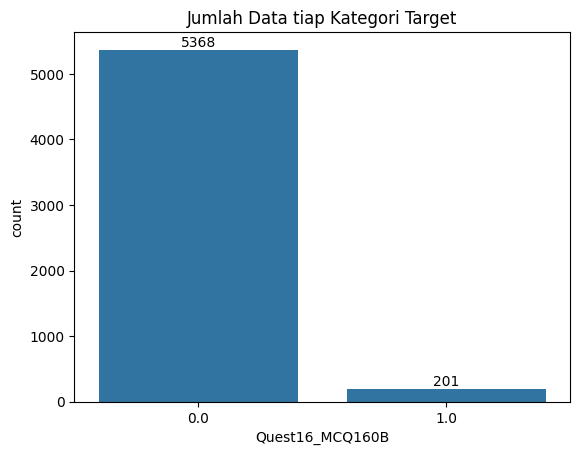

In [ ]:
ax = sns.barplot(y.value_counts())
ax.bar_label(ax.containers[0])

plt.title("Jumlah Data tiap Kategori Target")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

def prep_data(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)


  scaler = StandardScaler()
  X_resampled.iloc[:, 28:] = scaler.fit_transform(X_resampled.iloc[:, 28:])
  X_val.iloc[:, 28:] = scaler.transform(X_val.iloc[:, 28:])

  joblib.dump(scaler, 'standard_scaler.gz')

  X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
  X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

  print("Train: ", X_resampled.shape, " ", y_resampled.shape)
  print("Val: ", X_val.shape, " ", y_val.shape)
  print("Column Used: ", X.columns.tolist())

  return X_resampled, X_val, y_resampled, y_val

X_train, X_val, y_train, y_val = prep_data(df_raw)
input_shape = X_train.shape[1:]

print(y_train.value_counts())
print(y_val.value_counts())

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTENC

def prep_data_cross_validation(df, num_folds=5):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=37)

  for train_index, val_index in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index, :], X.iloc[val_index, :], y.iloc[train_index], y.iloc[val_index]
    # Instantiate the SMOTE oversampler
    smotenc = SMOTENC(
          categorical_features=categorical_cols,
          sampling_strategy='auto',
          random_state=37
        )

      # Apply SMOTE to generate synthetic samples
    X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled.iloc[:, 28:] = scaler.fit_transform(X_resampled.iloc[:, 28:])
    X_val.iloc[:, 28:] = scaler.transform(X_val.iloc[:, 28:])

    X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
    X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

    yield X_resampled, X_val, y_resampled, y_val


# Plot Shifting Using PCA

In [2]:

data_version = "Trained_V2-3.csv"

origin = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  origin = origin.set_index('SEQN', drop=True)
  origin = origin.drop(columns = "Unnamed: 0")
except:
  pass


data_version = "Trained_Oversampled-2.csv"

oversampled = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  oversampled = oversampled.set_index('SEQN', drop=True)
  oversampled = oversampled.drop(columns = "Unnamed: 0")
except:
  pass

oversampled.head()

,Dieta1_DRDINT,Dieta1_DR1TFIBE,Quest21_SLQ300,Quest19_PAD660,Quest19_PAQ635,Dieta1_DR1TCHOL,Quest19_PAQ655,Dieta1_DR1TSFAT,Dieta1_DR1TKCAL,Exami2_BMXBMI,...,Quest1_ALQ111,Quest10_ECQ020,Quest16_MCQ220,Quest4_CBD121,Quest16_MCQ366A,Labor2_URDFLOW1,Demog1_DMDEDUC,Quest9_DLQ050,Quest20_PFQ061C,Quest16_MCQ160B
0,1,0,2,2,2.0,0,2,1,0,2,...,1.0,9.0,2.0,7.500000e+01,2.0,1.204,2.0,2.0,1.0,0
1,1,2,2,2,2.0,0,2,1,0,0,...,2.0,9.0,2.0,5.397605e-79,2.0,0.500,1.0,2.0,2.0,0
2,0,2,2,1,2.0,2,1,2,1,3,...,9.0,9.0,2.0,4.000000e+01,2.0,0.107,4.0,1.0,9.0,0
3,1,3,1,0,1.0,3,3,3,3,0,...,1.0,9.0,2.0,8.570000e+02,2.0,0.605,5.0,2.0,9.0,0
4,1,1,2,1,1.0,1,2,3,2,0,...,1.0,9.0,2.0,4.000000e+01,2.0,0.706,3.0,2.0,1.0,0


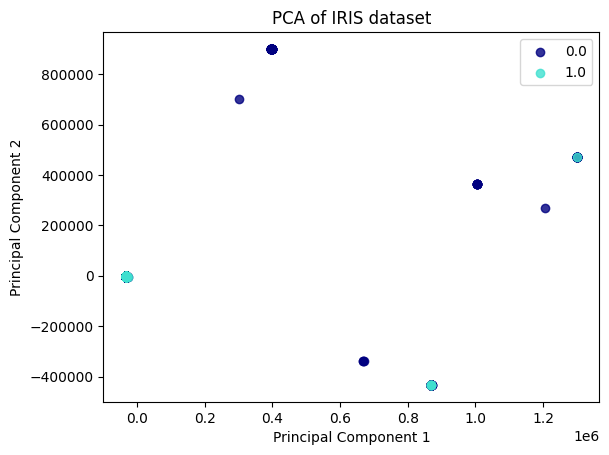

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

X = origin.copy().drop(columns=['Quest16_MCQ160B'])
y = origin['Quest16_MCQ160B']
y = y.replace({2: 0})
y = y.replace({9: 0})

target_names = y.unique()

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

# Plot the PCA results
plt.figure()
colors = ['navy', 'turquoise']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


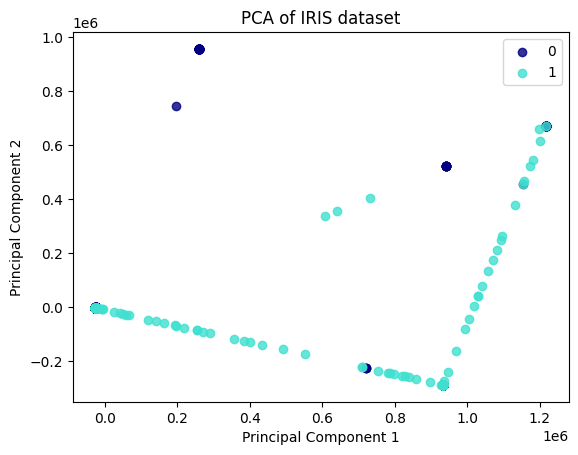

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

X = oversampled.copy().drop(columns=['Quest16_MCQ160B'])
y = oversampled['Quest16_MCQ160B']
y = y.replace({2: 0})
y = y.replace({9: 0})

target_names = y.unique()

# Apply PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

# Plot the PCA results
plt.figure()
colors = ['navy', 'turquoise']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


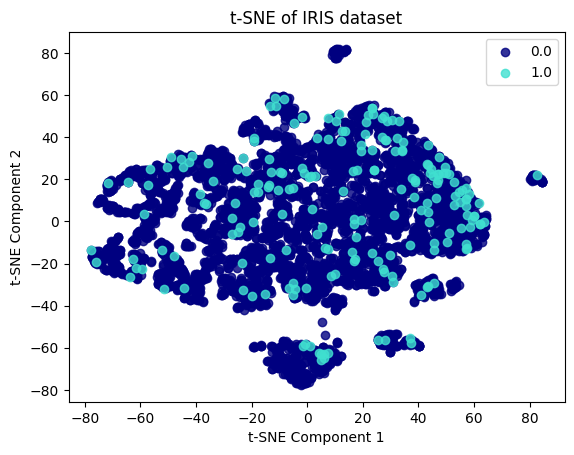

In [11]:
from sklearn.manifold import TSNE


X = origin.copy().drop(columns=['Quest16_MCQ160B'])
y = origin['Quest16_MCQ160B']
y = y.replace({2: 0})
y = y.replace({9: 0})

target_names = y.unique()

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure()
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], color=color, alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of IRIS dataset')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

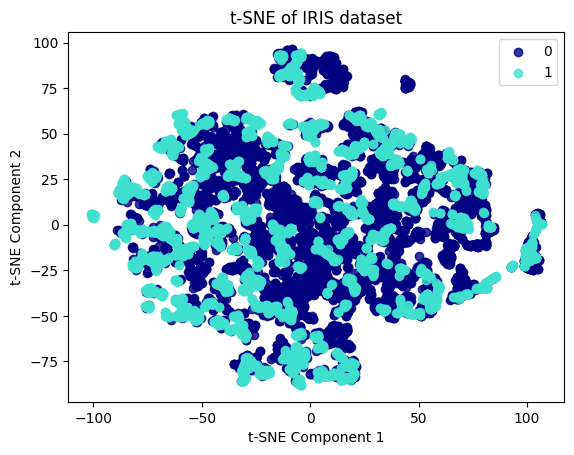

In [15]:
from sklearn.manifold import TSNE


X = oversampled.copy().drop(columns=['Quest16_MCQ160B'])
y = oversampled['Quest16_MCQ160B']
y = y.replace({2: 0})
y = y.replace({9: 0})

target_names = y.unique()

# Apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure()
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], color=color, alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE of IRIS dataset')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.show()

In [13]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00


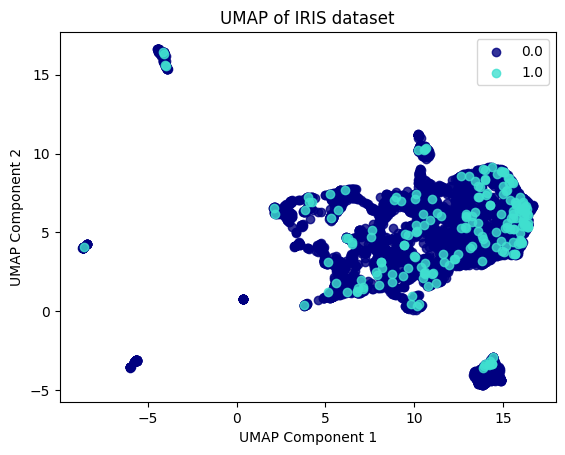

In [14]:
import umap

X = origin.copy().drop(columns=['Quest16_MCQ160B'])
y = origin['Quest16_MCQ160B']
y = y.replace({2: 0})
y = y.replace({9: 0})

target_names = y.unique()

# Apply UMAP to reduce the dimensionality to 2
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)

# Plot the UMAP results
plt.figure()
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], color=color, alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('UMAP of IRIS dataset')

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.show()

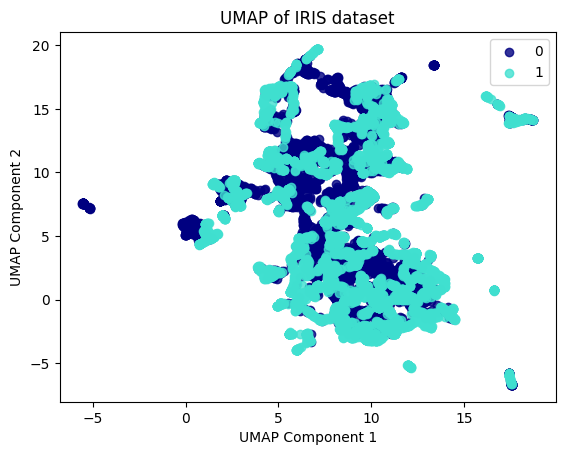

In [16]:
import umap

X = oversampled.copy().drop(columns=['Quest16_MCQ160B'])
y = oversampled['Quest16_MCQ160B']
y = y.replace({2: 0})
y = y.replace({9: 0})

target_names = y.unique()

# Apply UMAP to reduce the dimensionality to 2
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)

# Plot the UMAP results
plt.figure()
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], color=color, alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('UMAP of IRIS dataset')

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.show()